#(2) Implement Model B

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 17.0 MB/s eta 0:00:00


In [3]:
import datasets
from datasets import load_dataset
dataset = load_dataset('wmt16', 'de-en')

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

Dataset wmt16 downloaded and prepared to /root/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
!pip install transformers datasets evaluate sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

from transformers import BertTokenizer, BertForSequenceClassification

from datasets import load_dataset
import random
from tqdm import tqdm

In [6]:
from __future__ import print_function, division
from builtins import range, input
import pickle
import os, sys
import string
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import adam
from keras import optimizers
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [7]:
len(dataset['train'])//1135

4007

In [8]:
gr_train=[]
en_train=[]
for i in tqdm(range(0,len(dataset['train'])//1135)): 
   gr_train.append(dataset['train'][i]['translation']['de'])
   en_train.append(dataset['train'][i]['translation']['en']) 

100%|██████████| 4007/4007 [00:00<00:00, 8265.13it/s]


In [9]:
gr_val=[]
en_val=[]
for i in tqdm(range(0,len(dataset['validation']))): 
   gr_val.append(dataset['validation'][i]['translation']['de'])
   en_val.append(dataset['validation'][i]['translation']['en']) 

100%|██████████| 2169/2169 [00:00<00:00, 9402.93it/s]


In [10]:
gr_test=[]
en_test=[]
for i in tqdm(range(0,len(dataset['test']))): 
   gr_test.append(dataset['test'][i]['translation']['de'])
   en_test.append(dataset['test'][i]['translation']['en']) 

100%|██████████| 2999/2999 [00:00<00:00, 8340.00it/s]


Merging train & validation for efficient & sequencial loading into batch 

In [11]:
# 4548 +2169 = 6176
# do not run this cell twice
gr_train = gr_train + gr_val
en_train = en_train + en_val
print(len(gr_train))

6176


## Model Configurations

In [12]:
# config
BATCH_SIZE = 2
EPOCHS = 10
LATENT_DIM = 64
LATENT_DIM_DECODER = 64 
EMBEDDING_DIM = 50

In [13]:
input_texts = [] # English sentences
target_texts = [] # German sentences
target_texts_inputs = []# German sentences offset by 1 for teacher forcing

#Converting to lowercase
gr_train=[line.lower() for line in gr_train]
en_train=[line.lower() for line in en_train]
NUM_SAMPLES=len(gr_train)
print("Sample train size:",len(en_train))

Sample train size: 6176


##Preprocess

### Preprocess Training + Validation data

In [14]:
#Adding <sos> and <eos> tokens

# for lines in en_train:
for lines in gr_train:
    target_texts_inputs.append('<sos>'+" "+ lines)
    
# for lines in en_train:
for lines in gr_train:
    target_texts.append(lines+ " " +'<eos>')
    
# for lines in gr_train:
for lines in en_train:
    input_texts.append(lines)

In [15]:
# tokenize English sentences
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# word to index mapping for English
word2idx_inputs = tokenizer_inputs.word_index

# Max length of English sentence
max_len_input = max(len(s) for s in input_sequences)
max_len_input = 6

#tokenize German sentences
tokenizer_outputs = Tokenizer(filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# Word to index mapping for German
word2idx_outputs = tokenizer_outputs.word_index

# store number of output words for later
num_words_output = len(word2idx_outputs) + 1

# Max length of German sentence
max_len_target = max(len(s) for s in target_sequences)
max_len_target = 6

# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

print('Data Preprocessed')
print("Max train English sentence length:", max_len_target)
print("Max train German sentence length:", max_len_input)
print("Unique German Vocabulary count:",len(word2idx_inputs))
print("Unique English Vocabulary count:",len(word2idx_outputs))

Data Preprocessed
Max train English sentence length: 6
Max train German sentence length: 6
Unique German Vocabulary count: 11448
Unique English Vocabulary count: 22994


###Preprocess Test Data

In [16]:
##Test Preparation
input_texts_test = [] # English sentences
target_texts_test = [] # German sentences
target_texts_inputs_test = []# German sentences offset by 1 for teacher forcing

#Converting to lowercase
gr_test=[line.lower() for line in gr_test]
en_test=[line.lower() for line in en_test]

In [17]:
#Adding <sos> and <eos> tokens

for lines in gr_test:
    target_texts_inputs_test.append('<sos>'+" "+ lines)
    
for lines in gr_test:
    target_texts_test.append(lines+ " " +'<eos>')
    
for lines in en_test:
    input_texts_test.append(lines)

In [18]:

print(target_texts_test[0])
target_texts_inputs_test[0]


obama empfängt netanyahu <eos>


'<sos> obama empfängt netanyahu'

In [19]:
# tokenize English sentences

input_sequences_test = tokenizer_inputs.texts_to_sequences(input_texts_test)


target_sequences_test = tokenizer_outputs.texts_to_sequences(target_texts_test)
target_sequences_inputs_test = tokenizer_outputs.texts_to_sequences(target_texts_inputs_test)

# pad the sequences
encoder_inputs_test = pad_sequences(input_sequences_test, maxlen=max_len_input)
decoder_inputs_test = pad_sequences(target_sequences_inputs_test, maxlen=max_len_target, padding='post')
decoder_targets_test = pad_sequences(target_sequences_test, maxlen=max_len_target, padding='post')

print("Max test English sentence length:", decoder_inputs_test.shape[1])
print("Max test German sentence length:", encoder_inputs_test.shape[1])

Max test English sentence length: 6
Max test German sentence length: 6


###GloVe Embedding

In [ ]:
# download glove and unzip it in Notebook.
# !wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

SOURCE for GERMAN Word Vector:

https://github.com/jvparidon/subs2vec/#downloading-datasets

In [20]:
#Load pretrained word vectors from Glove
print('Loading word vectors...')
word2vec = {}

#/content/drive/MyDrive/2 Sem/DL/Assignments/A3_BharatGoyal_DebnathKundu_SaloniAgrawal/Q2/glove.6B/glove.6B.50d.txt
#/content/drive/MyDrive/2 Sem/DL/Assignments/A3_BharatGoyal_DebnathKundu_SaloniAgrawal/Q2/subs.de.vec
#/content/drive/MyDrive/2 Sem/DL/Assignments/A3_BharatGoyal_DebnathKundu_SaloniAgrawal/Q2/glove.6B/glove.6B.100d.txt
with open(os.path.join('/content/drive/MyDrive/2 Sem/DL/Assignments/A3_BharatGoyal_DebnathKundu_SaloniAgrawal/Q2/glove.6B/glove.6B.100d.txt'), encoding="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [21]:
EMBEDDING_DIM=100
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words=len(word2idx_inputs) + 1 #English vocab count+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < num_words:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [22]:
embedding_matrix[89]

array([-1.78639993e-01,  1.49169996e-01,  5.12189984e-01, -2.84119993e-01,
        6.22409999e-01,  7.78639972e-01, -6.16559992e-03,  7.72970021e-02,
        2.49870002e-01,  9.02170017e-02, -1.06880002e-01,  3.84860009e-01,
       -9.19039994e-02,  6.36150002e-01,  2.41280004e-01, -2.27149993e-01,
        3.35359991e-01,  5.08029997e-01, -2.78389990e-01, -4.37779993e-01,
        5.71139991e-01,  5.94850004e-01,  8.11209977e-01,  1.94389999e-01,
        2.56630003e-01, -1.71579998e-02, -2.64030010e-01, -3.65310013e-01,
        7.23109990e-02,  1.34059995e-01, -1.59229994e-01,  4.64749992e-01,
       -4.95860010e-01, -4.36650008e-01, -7.87239969e-02,  1.17470004e-01,
       -7.22479969e-02,  1.72920004e-01, -2.49770001e-01,  6.66100008e-04,
       -6.62989974e-01, -7.91779995e-01, -4.90810007e-01, -2.01949999e-01,
        4.14520018e-02,  5.23859978e-01, -3.47059995e-01,  5.53730011e-01,
        3.66100013e-01, -3.25760007e-01, -4.32020009e-01,  3.18980008e-01,
        2.12980002e-01,  

##Creating the Model

Define Softmax Activation Function

In [23]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

Define Embedding Layer

In [24]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

One-hot Encoding

In [25]:
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

Define Encoding Layer

In [26]:
#encoder
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True, dropout=0.2
))
encoder_outputs = encoder(x)

Define Decoder Layer

In [29]:
#Decoder
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

###Define Attention Layers

In this implementation, the ***window_size*** parameter specifies the size of the local attention window, which is applied to the encoder outputs at each decoder time step.

The attention mechanism calculates attention scores for each encoder output within the window, and then computes a weighted average of the encoder outputs based on these scores to obtain a context vector, which is used to modulate the decoder output.

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dot, Concatenate

# Define the model architecture
def create_model(input_dim, output_dim, hidden_dim, window_size):
    # Define the input sequences
    encoder_inputs = Input(shape=(None, input_dim))
    decoder_inputs = Input(shape=(None, output_dim))
    
    # Define the LSTM encoder
    encoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    
    # Define the LSTM decoder
    decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    
    # Define the local attention mechanism
    attention_layer = Dot(axes=[2, 2])
    context_layer = Concatenate(axis=2)
    attention_weights = []
    for t in range(output_dim):
        attention_input = decoder_outputs[:, t:t+window_size, :]
        attention_score = attention_layer([attention_input, encoder_outputs])
        attention_weight = Dense(1, activation='softmax')(attention_score)
        attention_weights.append(attention_weight)
        context_vector = Dot(axes=[1, 1])([attention_weight, encoder_outputs])
        decoder_outputs = context_layer([decoder_outputs, context_vector])
    
    # Define the output layer
    output_layer = Dense(output_dim, activation='softmax')
    decoder_outputs = output_layer(decoder_outputs)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    return model


In [30]:
# #Attention
# attn_repeat_layer = RepeatVector(max_len_input)
# attn_concat_layer = Concatenate(axis=-1)
# attn_dense1 = Dense(3, activation='tanh') #10
# attn_dense2 = Dense(1, activation=softmax_over_time)

# attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

In [31]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context

In [32]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [33]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in tqdm(range(max_len_target)): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


In [34]:
def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layerx``
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [35]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

##Model Training

In [36]:
learning_rate=0.005
# checkpoint
filepath="german_eng_finalmodel"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# compile the model

model.compile(optimizer=optimizers.Adam(learning_rate) ,loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 6, 100)       1144900     ['input_1[0][0]']                
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 6, 128)       84480       ['embedding[0][0]']              
                                                                                              

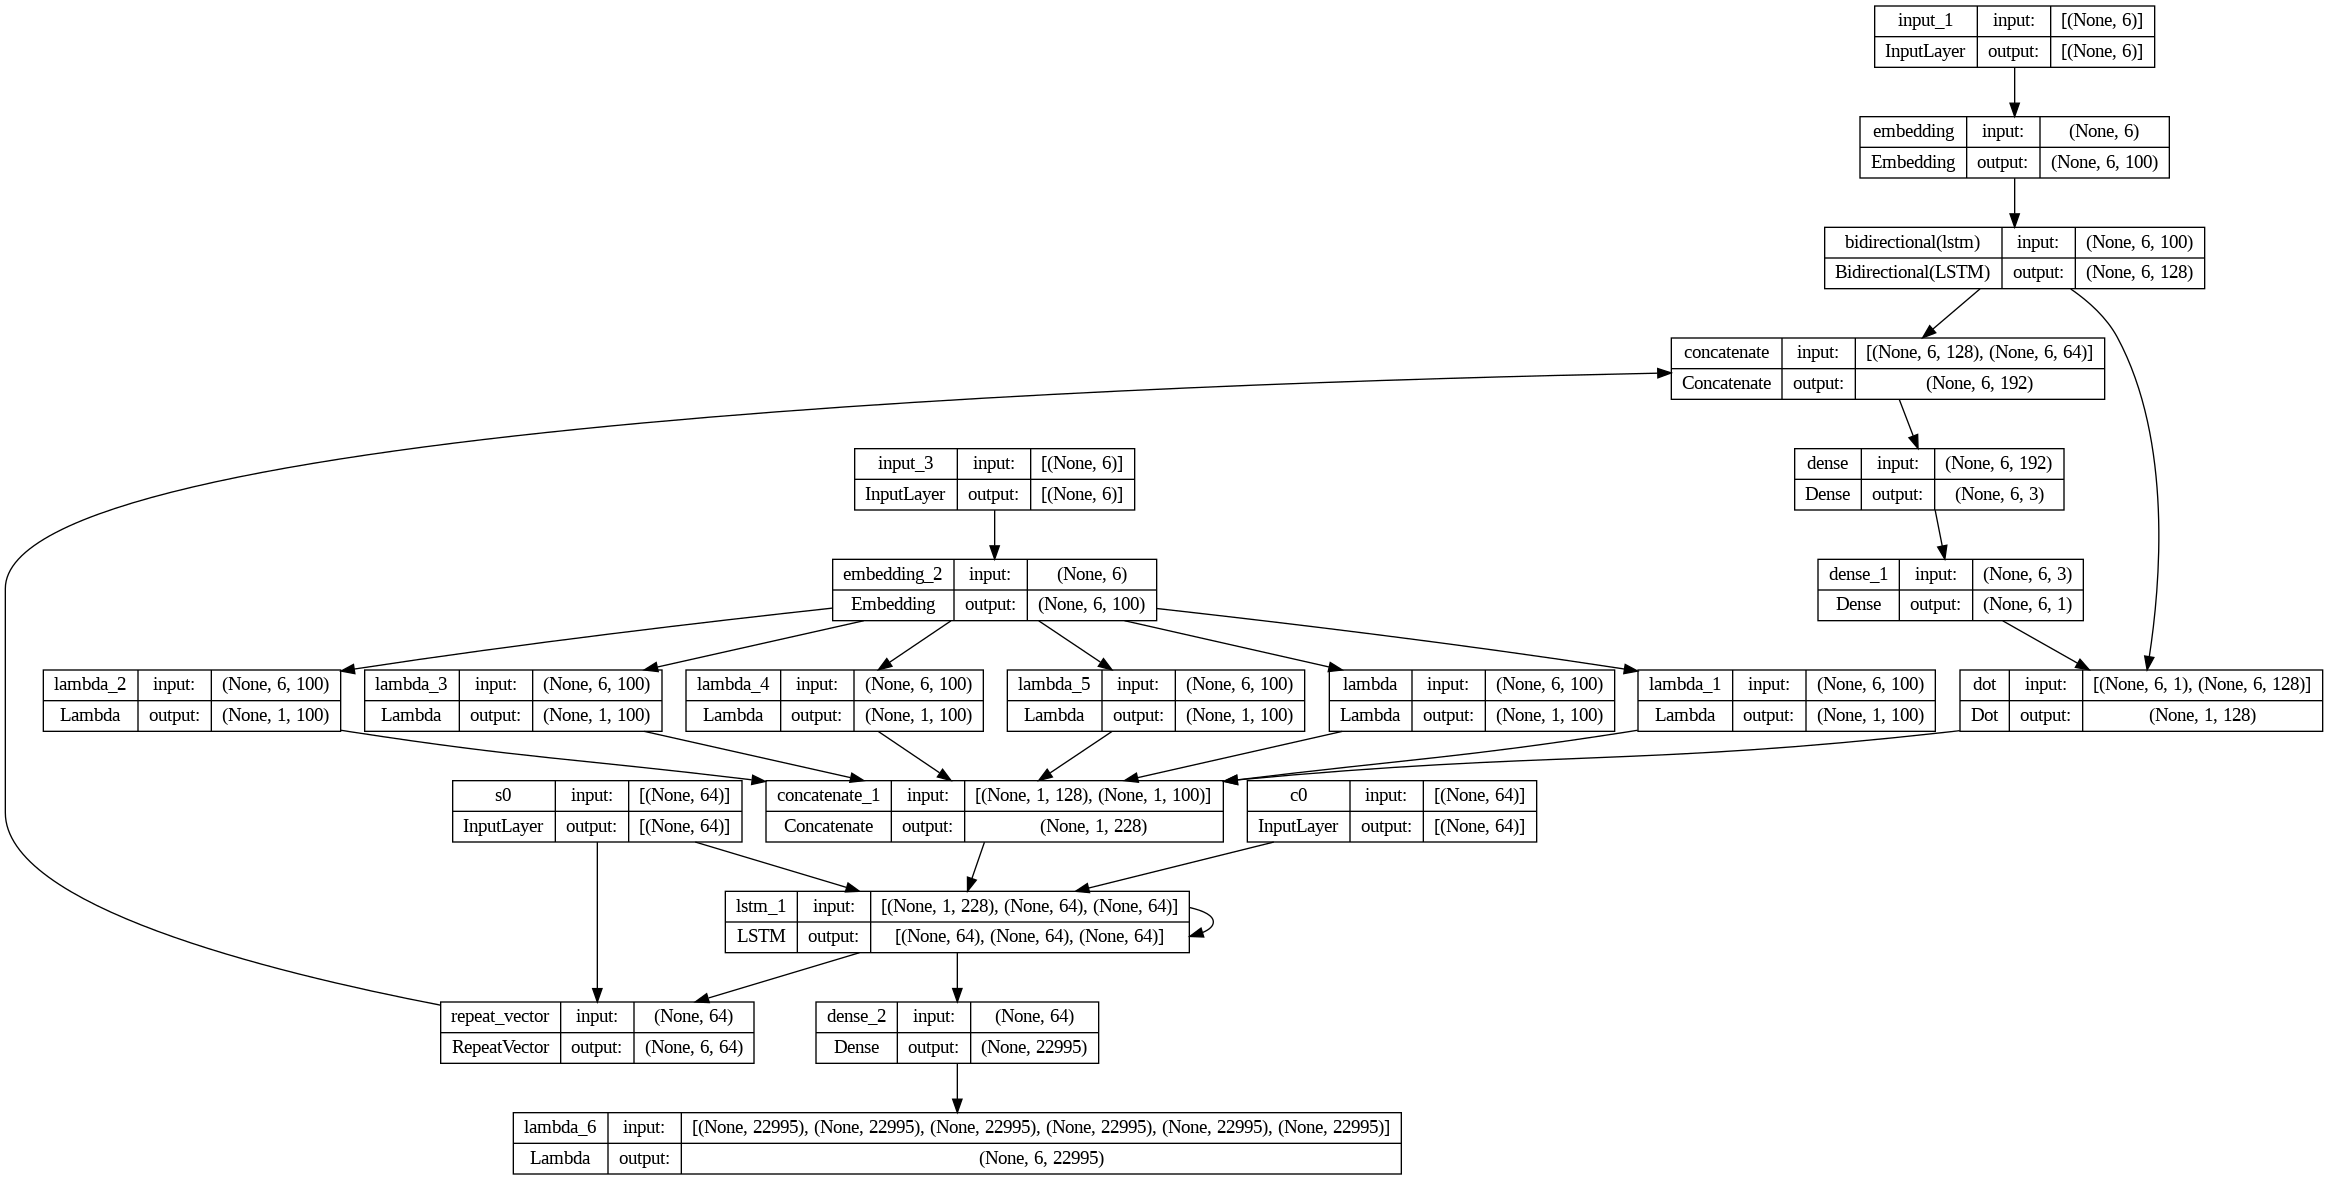

In [38]:
from keras.utils import plot_model

plot_model(model, to_file='model_trn_plot.png', show_shapes=True, show_layer_names=True)


In [39]:
EPOCHS = 12

# train the model
z = np.zeros((encoder_inputs.shape[0], LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.25,
    callbacks=callbacks_list
)

Epoch 1/12
2314/2316 [============================>.] - ETA: 0s - loss: 7.2968 - accuracy: 0.1815
Epoch 1: val_accuracy improved from -inf to 0.17401, saving model to german_eng_finalmodel


2316/2316 [==============================] - 94s 34ms/step - loss: 7.2965 - accuracy: 0.1815 - val_loss: 7.8813 - val_accuracy: 0.1740
Epoch 2/12
2314/2316 [============================>.] - ETA: 0s - loss: 6.3934 - accuracy: 0.1981
Epoch 2: val_accuracy improved from 0.17401 to 0.19376, saving model to german_eng_finalmodel


2316/2316 [==============================] - 78s 34ms/step - loss: 6.3931 - accuracy: 0.1981 - val_loss: 8.2867 - val_accuracy: 0.1938
Epoch 3/12
2313/2316 [============================>.] - ETA: 0s - loss: 5.8522 - accuracy: 0.2234
Epoch 3: val_accuracy improved from 0.19376 to 0.20812, saving model to german_eng_finalmodel


2316/2316 [==============================] - 78s 34ms/step - loss: 5.8521 - accuracy: 0.2234 - val_loss: 8.3934 - val_accuracy: 0.2081
Epoch 4/12
2316/2316 [==============================] - ETA: 0s - loss: 5.3291 - accuracy: 0.2451
Epoch 4: val_accuracy improved from 0.20812 to 0.22927, saving model to german_eng_finalmodel


2316/2316 [==============================] - 79s 34ms/step - loss: 5.3291 - accuracy: 0.2451 - val_loss: 8.3520 - val_accuracy: 0.2293
Epoch 5/12
2316/2316 [==============================] - ETA: 0s - loss: 4.8069 - accuracy: 0.2686
Epoch 5: val_accuracy improved from 0.22927 to 0.23715, saving model to german_eng_finalmodel


2316/2316 [==============================] - 78s 34ms/step - loss: 4.8069 - accuracy: 0.2686 - val_loss: 8.3689 - val_accuracy: 0.2372
Epoch 6/12
2313/2316 [============================>.] - ETA: 0s - loss: 4.3294 - accuracy: 0.2936
Epoch 6: val_accuracy improved from 0.23715 to 0.24342, saving model to german_eng_finalmodel


2316/2316 [==============================] - 79s 34ms/step - loss: 4.3299 - accuracy: 0.2935 - val_loss: 8.3741 - val_accuracy: 0.2434
Epoch 7/12
2316/2316 [==============================] - ETA: 0s - loss: 3.8698 - accuracy: 0.3197
Epoch 7: val_accuracy improved from 0.24342 to 0.24428, saving model to german_eng_finalmodel


2316/2316 [==============================] - 79s 34ms/step - loss: 3.8698 - accuracy: 0.3197 - val_loss: 8.4842 - val_accuracy: 0.2443
Epoch 8/12
2316/2316 [==============================] - ETA: 0s - loss: 3.4844 - accuracy: 0.3562
Epoch 8: val_accuracy improved from 0.24428 to 0.25130, saving model to german_eng_finalmodel


2316/2316 [==============================] - 78s 34ms/step - loss: 3.4844 - accuracy: 0.3562 - val_loss: 8.5320 - val_accuracy: 0.2513
Epoch 9/12
2313/2316 [============================>.] - ETA: 0s - loss: 3.1937 - accuracy: 0.3886
Epoch 9: val_accuracy improved from 0.25130 to 0.25453, saving model to german_eng_finalmodel


2316/2316 [==============================] - 77s 33ms/step - loss: 3.1935 - accuracy: 0.3887 - val_loss: 8.5556 - val_accuracy: 0.2545
Epoch 10/12
2313/2316 [============================>.] - ETA: 0s - loss: 2.9750 - accuracy: 0.4147
Epoch 10: val_accuracy did not improve from 0.25453
2316/2316 [==============================] - 55s 24ms/step - loss: 2.9751 - accuracy: 0.4147 - val_loss: 8.6559 - val_accuracy: 0.2504
Epoch 11/12
2316/2316 [==============================] - ETA: 0s - loss: 2.7931 - accuracy: 0.4379
Epoch 11: val_accuracy did not improve from 0.25453
2316/2316 [==============================] - 51s 22ms/step - loss: 2.7931 - accuracy: 0.4379 - val_loss: 8.7017 - val_accuracy: 0.2491
Epoch 12/12
2313/2316 [============================>.] - ETA: 0s - loss: 2.6048 - accuracy: 0.4629
Epoch 12: val_accuracy did not improve from 0.25453
2316/2316 [==============================] - 52s 22ms/step - loss: 2.6050 - accuracy: 0.4628 - val_loss: 8.7593 - val_accuracy: 0.2444


##Graphs

In [40]:
print("Train loss: ",r.history['loss'])
print("Validation loss: ",r.history['val_loss'])

Train loss:  [7.296464443206787, 6.393141269683838, 5.8521199226379395, 5.329128265380859, 4.806881904602051, 4.329912185668945, 3.869786262512207, 3.4843904972076416, 3.1934525966644287, 2.975116491317749, 2.793137550354004, 2.6050045490264893]
Validation loss:  [7.88133430480957, 8.28666877746582, 8.393394470214844, 8.351982116699219, 8.368884086608887, 8.374067306518555, 8.484201431274414, 8.531977653503418, 8.555588722229004, 8.655937194824219, 8.701656341552734, 8.759346008300781]


In [41]:
val_loss=r.history['val_loss']
print(val_loss)
val_loss.reverse()
print(val_loss)

[7.88133430480957, 8.28666877746582, 8.393394470214844, 8.351982116699219, 8.368884086608887, 8.374067306518555, 8.484201431274414, 8.531977653503418, 8.555588722229004, 8.655937194824219, 8.701656341552734, 8.759346008300781]
[8.759346008300781, 8.701656341552734, 8.655937194824219, 8.555588722229004, 8.531977653503418, 8.484201431274414, 8.374067306518555, 8.368884086608887, 8.351982116699219, 8.393394470214844, 8.28666877746582, 7.88133430480957]


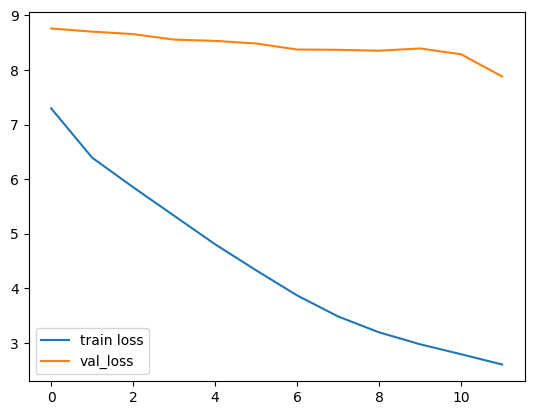

In [42]:
# plot loss
# plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

In [43]:
print("Train accuracy: ",r.history['accuracy'])
print("Validation accuracy: ",r.history['val_accuracy'])

Train accuracy:  [0.18149107694625854, 0.19807858765125275, 0.2233736366033554, 0.24514248967170715, 0.2685664892196655, 0.2934657335281372, 0.31966033577919006, 0.35618162155151367, 0.38867300748825073, 0.4146876931190491, 0.43785980343818665, 0.46279504895210266]
Validation accuracy:  [0.17400690913200378, 0.19376079738140106, 0.20811744034290314, 0.22927461564540863, 0.23715457320213318, 0.24341537058353424, 0.2442789226770401, 0.2512953281402588, 0.25453367829322815, 0.25043177604675293, 0.24913644790649414, 0.24438686668872833]


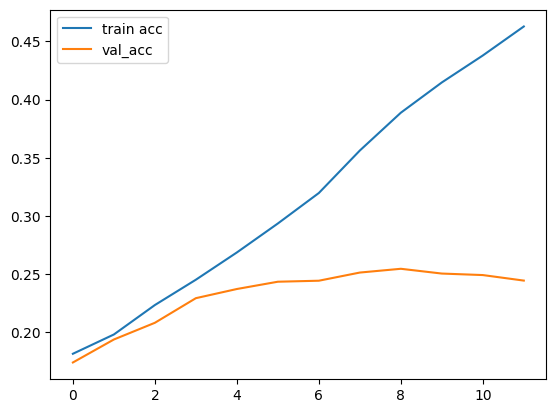

In [44]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

##Modifying the model for Predictions

In [45]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [46]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)

In [47]:
decoder_model.save("enfr_decoder_model.h5")
encoder_model.save("enfr_encoder_model.h5")

##Making Predictions

In [48]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [49]:
import pickle
pickle.dump( idx2word_eng, open( "idx2word_eng1.pkl", "wb" ) )
pickle.dump(idx2word_trans,open("idx2word_fr.pkl","wb"))
pickle.dump(tokenizer_inputs,open("tokenizer_inputs.pkl","wb"))

In [50]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

##Testing the model

In [51]:
test_actual_sentence=[]
test_predicted_sentence=[]

for i in range(len(en_test)//6):
    # Do some test translations
  
  input_seq = encoder_inputs_test[i:i+1]
  translation = decode_sequence(input_seq)

  test_actual_sentence.append(target_texts_test[i])
  test_predicted_sentence.append(translation)
  print("..........................................")

1/1 [==============================] - 0s 22ms/step
..........................................
1/1 [==============================] - 0s 22ms/step
..........................................
1/1 [==============================] - 0s 23ms/step
..........................................
1/1 [==============================] - 0s 21ms/step
..........................................
1/1 [==============================] - 0s 26ms/step
..........................................
1/1 [==============================] - 0s 29ms/step
..........................................
1/1 [==============================] - 0s 25ms/step
..........................................
1/1 [==============================] - 0s 21ms/step
..........................................
1/1 [==============================] - 0s 22ms/step
..........................................
1/1 [==============================] - 0s 30ms/step
..........................................
1/1 [==============================] - 0s 34ms/ste

In [52]:
#printing some sample predictions

for i in range(0,50):
    print('-')
    print('Input sentence:', input_texts_test[i])
    print('Predicted translation:', test_predicted_sentence[i])
    print('Actual translation:', target_texts_test[i])

-
Input sentence: obama receives netanyahu
Predicted translation: die die die nicht
Actual translation: obama empfängt netanyahu <eos>
-
Input sentence: the relationship between obama and netanyahu is not exactly friendly.
Predicted translation: danach steht, immer standpunkt
Actual translation: das verhältnis zwischen obama und netanyahu ist nicht gerade freundschaftlich. <eos>
-
Input sentence: the two wanted to talk about the implementation of the international agreement and about teheran's destabilising activities in the middle east.
Predicted translation: danach steht, der standpunkt leistungspotential.
Actual translation: die beiden wollten über die umsetzung der internationalen vereinbarung sowie über teherans destabilisierende maßnahmen im nahen osten sprechen. <eos>
-
Input sentence: the meeting was also planned to cover the conflict with the palestinians and the disputed two state solution.
Predicted translation: danach steht, eine elektronischen zeichnete?
Actual translation

##Evaluation metric: BLEU Score

In [53]:
import nltk
pred=[]
for words in test_predicted_sentence:
    pred.append(words.split())

In [54]:
actual=[]
for words in test_actual_sentence:
    actual.append(words.split())

In [55]:
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()
BLEUscore = nltk.translate.bleu_score.corpus_bleu(actual,pred,smoothing_function=chencherry.method4)
print(BLEUscore)

0.0003053687253683748


In [56]:
import sacrebleu
x=sacrebleu.raw_corpus_bleu(test_predicted_sentence,[test_actual_sentence])
print(x)

BLEU = 0.00 2.4/0.0/0.0/0.0 (BP = 0.050 ratio = 0.250 hyp_len = 2463 ref_len = 9839)


##Bleu-1 Score

In [57]:
import evaluate
bleu = evaluate.load("bleu")

results = bleu.compute(predictions=test_predicted_sentence, references=test_actual_sentence,max_order=1)
print(results)

{'bleu': 0.018143007548993544, 'precisions': [0.2340057636887608], 'brevity_penalty': 0.07753231058498473, 'length_ratio': 0.2811310054281779, 'translation_length': 3470, 'reference_length': 12343}


In [58]:
print(results['bleu'])

0.018143007548993544


Overall **Bleu-1** score: **0.018143007548993544** over all the samples in the test set

##Bleu-2 Score

In [59]:
import evaluate
bleu = evaluate.load("bleu")

results = bleu.compute(predictions=test_predicted_sentence, references=test_actual_sentence,max_order=2)
print(results)

{'bleu': 0.0013761781996548899, 'precisions': [0.2340057636887608, 0.0013463480309660047], 'brevity_penalty': 0.07753231058498473, 'length_ratio': 0.2811310054281779, 'translation_length': 3470, 'reference_length': 12343}


In [60]:
print(results['bleu'])

0.0013761781996548899


Overall **Bleu-2** score: **0.0013761781996548899** over all the 
samples in the test set

##Evaluation metric: Rouge-L Score

In [61]:
!pip install evaluate
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=5884b230d60b79d7a52ce26d44377ee010d75de86b5c63a1cb8da271fd6be094
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge_score


In [62]:
import evaluate
r = evaluate.load('rouge')

results = r.compute(predictions=test_predicted_sentence, references=test_actual_sentence)
print(results)

{'rouge1': 0.011500000563772626, 'rouge2': 0.0, 'rougeL': 0.011367996202336292, 'rougeLsum': 0.011297975999443701}


In [63]:
print(results['rougeL'])

0.011367996202336292


Overall **ROUGE-L** score: **0.011367996202336292** over all the samples in the test set